# Neural Network Use for Classification 

## Classify Handwritten Numbers

### 11-01-2022
- **Goal:** This attempts to create a method to classify handwritten numbers. The client known as FakeBank has a need to start classifying numbers which have been handwritten in various types of handwriting. This will enable the bank to start a basic neural network of recognizing digits 0-9 first, which can then be transferred to learning larger numbers commonly written on checks.

- **Work Completed**: Firstly, I accessed the MNIST dataset from the Keras dataset library. From there, I converted the classes to categorical class matrices, ensured the data was parsed as floats, created some initial metrics like shapes, and plotted 25 random images from the dataset. I then put each task into its own section which follows the lesson taught in [Introduction to Neural Networks](https://app.thisismetis.com/courses/222/pages/home-introduction-to-neural-networks). EDA was performed, and then I created a baseline logistic regression model noting the accuracy score. From there, a CNN model using Keras was created for which inference was done on the test set as well as a completely separate image I made from writing a number down, taking the picture, uploading it to a directory, then importing and converting the image to the needed formats for model inference.

- **Recent Findings:** The baseline accuracy from the logistic regression was 0.8972 to where after 20 epochs the validation accuracy score of the CNN is 0.9907. Transfer learning was performed with a known preset CNN model called ResNet-50, reshaped to 28x28x3, to which the accuracy score is .926 with 20 epochs.

### Imports

In [1]:
import numpy as np
import cv2
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from pylab import rcParams

from sklearn import datasets, preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam

### EDA

#### Load MNIST Dataset

In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
mnist = datasets.load_digits()
images = mnist.images
labels = mnist.target
data_size = len(images)

In [3]:
# shapes
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"shape of first image (X_train[0]): {X_train[0].shape}")

print(f"\nX_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

# Number of samples in dataset
print(f"\ntrain samples: {X_train.shape[0]}")
print(f"test samples: {X_test.shape[0]}")

X_train shape: (60000, 28, 28)
y_train shape: (60000,)
shape of first image (X_train[0]): (28, 28)

X_test shape: (10000, 28, 28)
y_test shape: (10000,)

train samples: 60000
test samples: 10000


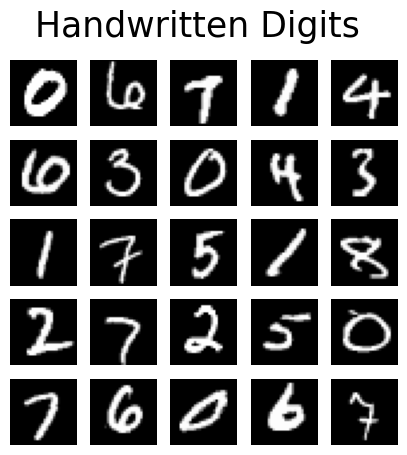

In [4]:
# set figure size
rcParams['figure.figsize'] = 5,5

# number of columns and rows in which images needs to be displayed
num_row = 5
num_col = 5

# to get 4 * 4 = 16 images together
pic_id = np.random.randint(0, len(X_train), num_row * num_col)

# create subplots
fig, axes = plt.subplots(num_row, num_col)

# title
plt.suptitle('Handwritten Digits', fontsize=25)

# subplots
for i in range(0, num_row):
    for j in range(0, num_col):
        k = (i * num_col) + j
        axes[i,j].imshow(X_train[pic_id[k]], cmap=plt.get_cmap('gray'))
        # switch off x/y axis labels
        axes[i,j].axis('off')

### Build network structure

In [5]:
# define number of classes
num_classes = 10

# convert class vectors to binary class matrices
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

# parse numbers as floats which will speed up training
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# normalize data into the [latex][-1, 1][/latex] range
X_train /= 255.
X_test /= 255.

#### Baseline logistic regression

In [6]:
# preprocess
images = images.reshape(len(images), -1)
images = preprocessing.scale(images)

# train test split
split = 0.80
X_train_lr, y_train_lr = images[:int(data_size * split)], labels[:int(data_size * split)]
X_test_lr, y_test_lr = images[int(data_size * split):], labels[int(data_size * split):]

# initialize model
lr = LogisticRegression()

# train the lr on X_train, y_train
lr.fit(X_train_lr, y_train_lr)

# make predictions
predictions = lr.predict(X_test_lr)

print(f"baseline accuracy score: {accuracy_score(y_test_lr, predictions)}")

baseline accuracy score: 0.8972222222222223


#### CNN model

In [7]:
# reshape for keras
X_train = np.expand_dims(X_train, -1)
X_test = np.expand_dims(X_test, -1)

In [8]:
def get_uncompiled_model():

    model = Sequential()

    # 2 convolutional layers with 16 units
    model.add(Conv2D(16, kernel_size=3, input_shape=(28,28,1), padding='same', activation="relu"))

    # pooling - look at the grid (2x2) and use max only
    # removes the number of parameters used and leaves most significant to prevent overfitting and reduces memory
    model.add(MaxPooling2D())
    model.add(Conv2D(32, kernel_size=3, padding='same', activation="relu"))
    model.add(MaxPooling2D())    

    # from the reference from Andrew Kruger, PhD as included in the reference section:
    # The neural network ultimately needs to output the probability of the different classes in an array. 
    # After the convolution stacks, the probabilities need to be flattened to a 1D feature vector. 
    # The dense layers are fully-connected layers that apply transformations and change the dimensions. 
    # The final dense layer needs to be the same length as the number of classes, and gives the probability of each class.

    # post convolutional stacks
    # flatten to a 1d vector
    model.add(Flatten())

    # add the dense layer - 128 units
    model.add(Dense(128))
    model.add(Activation('relu'))
    # if overfit, uncomment
    #model.add(Dropout(0.2))

    # add the final dense layer
    num_classes = 10
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    return model

### Compile the model

In [9]:
# initiate optimizer choice and train

def get_compiled_model():
    
    model = get_uncompiled_model()
    opt = Adam(lr=1e-3)
    model.compile(loss='categorical_crossentropy',
                    optimizer=opt, 
                    metrics=['accuracy'])

    return model

In [10]:
# show summary stats
model = get_compiled_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1568)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               200832    
_________________________________________________________________
activation (Activation)      (None, 128)               0

2022-11-01 17:49:27.707374: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-11-01 17:49:27.707570: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Fit the model to training data

In [11]:
history = model.fit(
                X_train, 
                y_train, 
                epochs=20, 
                batch_size=16, 
                validation_data=(X_test, y_test)
)

# uncomment to save model for transfer learning
# save architecture

# model_json = model.to_json()
# with open("cnn_model.json", "w") as json_file:
#     json_file.write(model_json)

# save weights
# model.save_weights("cnn_model_weights.h5")

# to load later on
# from tensorflow.keras.models import model_from_json
# model = model_from_json(json_string)
# model.load_weights('my_model_weights.h5')

2022-11-01 17:49:27.837367: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


Epoch 1/20
3750/3750 [==============================] - 15s 4ms/step - loss: 0.2773 - accuracy: 0.9142 - val_loss: 0.0412 - val_accuracy: 0.9865
Epoch 2/20
3750/3750 [==============================] - 15s 4ms/step - loss: 0.0441 - accuracy: 0.9859 - val_loss: 0.0298 - val_accuracy: 0.9900
Epoch 3/20
3750/3750 [==============================] - 16s 4ms/step - loss: 0.0288 - accuracy: 0.9909 - val_loss: 0.0297 - val_accuracy: 0.9896
Epoch 4/20
3750/3750 [==============================] - 17s 5ms/step - loss: 0.0198 - accuracy: 0.9935 - val_loss: 0.0303 - val_accuracy: 0.9903
Epoch 5/20
3750/3750 [==============================] - 19s 5ms/step - loss: 0.0146 - accuracy: 0.9950 - val_loss: 0.0302 - val_accuracy: 0.9905
Epoch 6/20
3750/3750 [==============================] - 20s 5ms/step - loss: 0.0108 - accuracy: 0.9966 - val_loss: 0.0358 - val_accuracy: 0.9895
Epoch 7/20
3750/3750 [==============================] - 21s 6ms/step - loss: 0.0096 - accuracy: 0.9968 - val_loss: 0.0315 - val_ac

### Make predictions for new data

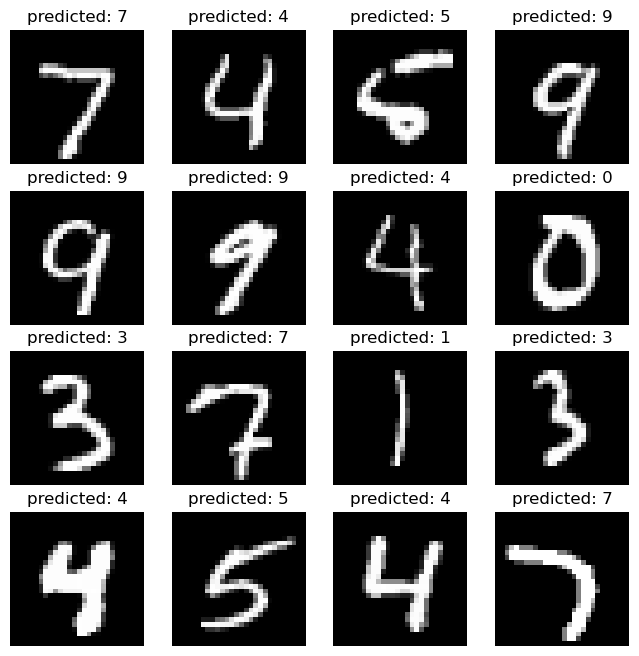

In [12]:
predictions = model.predict(X_test, batch_size=None, verbose=0, steps=None)
predictions = np.argmax(predictions, axis=1)

idx = 0
f, axarr = plt.subplots(4, 4, figsize=(8,8))

for i in range(4):
    for j in range(4):
        axarr[i,j].imshow(np.squeeze(X_test[idx]), cmap=plt.get_cmap('gray'))
        axarr[i,j].set_title("predicted: " + str(predictions[idx]),fontsize=12)
        axarr[i,j].axis('off')
        idx += 4

##### Handwritten and Uploaded

image shape: (1, 28, 28, 1)


/Users/randy.grant/opt/anaconda3/envs/deep_learning/lib/python3.8/site-packages/matplotlib/text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


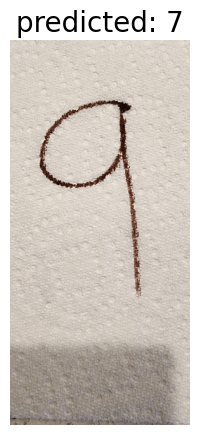

In [13]:
def input_prepare(img):
    img = np.asarray(img)
    img = cv2.resize(img, (28, 28))
    img = img / 255
    img = img.reshape(1,28,28,1)
    return img 

img = cv2.imread('./images/handwritten.jpeg')
orig = img.copy()
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = input_prepare(img)
print(f"image shape: {img.shape}")


pred = model.predict(img)
plt.imshow(cv2.cvtColor(orig, cv2.COLOR_BGR2RGB))
plt.title(np.argmax(pred, axis=1))
plt.title("predicted: " + str(predictions[idx]),fontsize=20)
plt.axis('off')

plt.show();

### Evaluate results

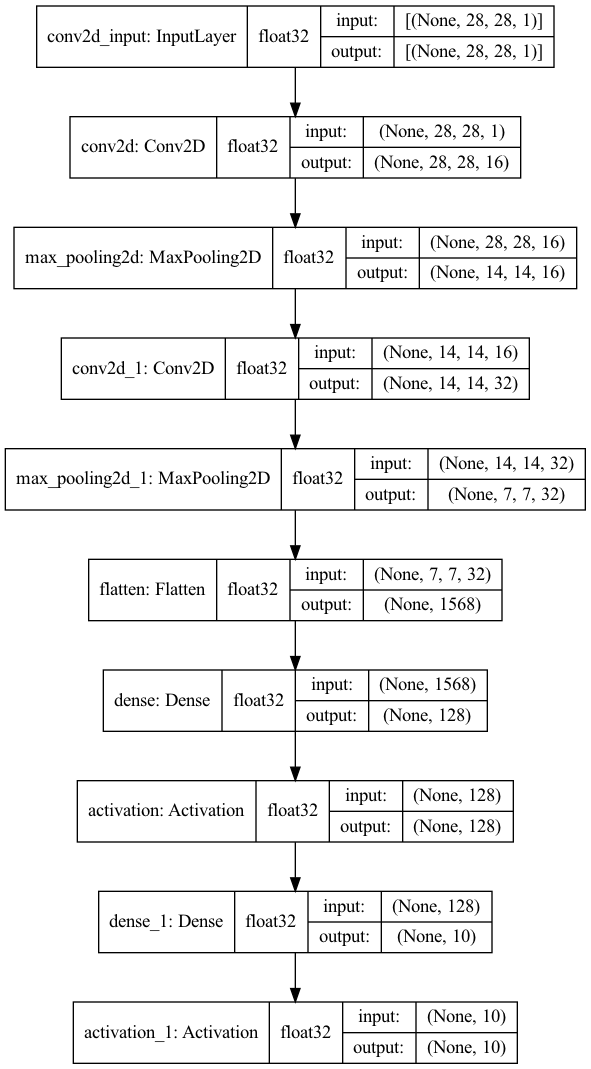

In [14]:
keras.utils.plot_model(
    model,
    to_file='model-details.png',
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=True,
    dpi=96
)

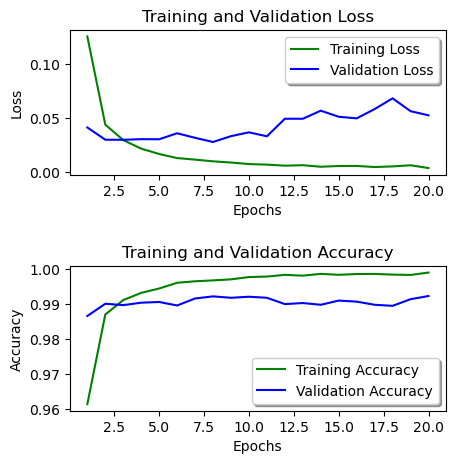

In [15]:
# plot loss and accuracy
fig, ax = plt.subplots(2,1)
epochs = range(1,21)

loss_train = history.history['loss']
loss_val = history.history['val_loss']
ax[0].plot(epochs, loss_train, 'g', label='Training Loss')
ax[0].plot(epochs, loss_val, 'b', label='Validation Loss')
ax[0].set_title('Training and Validation Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend(loc='best', shadow=True)


acc_train = history.history['accuracy']
acc_val = history.history['val_accuracy']
ax[1].plot(epochs, acc_train, 'g', label='Training Accuracy')
ax[1].plot(epochs, acc_val, 'b', label='Validation Accuracy')
ax[1].set_title('Training and Validation Accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend(loc='best', shadow=True)

fig.tight_layout(pad=2.0)

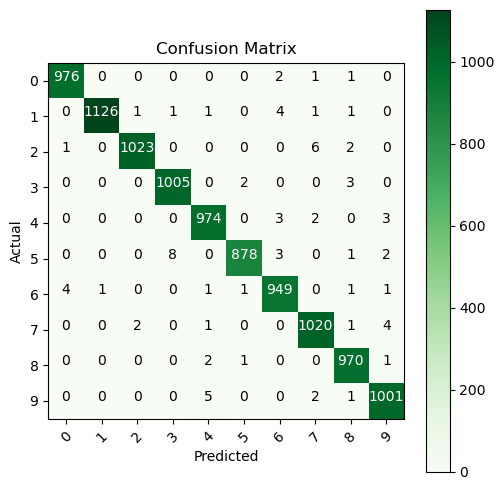

In [16]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion Matrix',
                          cmap=plt.cm.Greens):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Actual')
    plt.xlabel('Predicted')

# Predict the values from the validation dataset
Y_pred = model.predict(X_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred, axis=1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test, axis=1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes=range(10)) 

#### Transfer learning

In [17]:
# get the fresh mnist dataset
from tensorflow.keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# reshape the data
X_train_tr = X_train.reshape((X_train.shape[0], 28, 28))
X_test_tr = X_test.reshape((X_test.shape[0], 28, 28))

# parse numbers as floats which will speed up training
X_train_tr = X_train.astype('float32')
X_test_tr = X_test.astype('float32')

# convert data to 3 channels
X_train_tr = np.stack((X_train_tr,)*3, axis=-1)
X_test_tr = np.stack((X_test_tr,)*3, axis=-1)

y_train_tr = to_categorical(y_train)
y_test_tr = to_categorical(y_test)

# data augmentation with generator
train_generator = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 40,
    shear_range = 0.2,
    zoom_range = 0.2,
    fill_mode = 'nearest'
)

val_generator = ImageDataGenerator(rescale = 1./255)
train_iterator = train_generator.flow(X_train_tr, y_train_tr, batch_size=16, shuffle=True)
val_iterator = val_generator.flow(X_test_tr, y_test_tr, batch_size=16, shuffle=False)

In [18]:
model = Sequential()
# add the pretrained model
model.add(ResNet50(include_top=False, pooling='avg', weights='imagenet'))
# add fully connected layer with output
model.add(Dense(512, activation='relu'))
model.add(Dense(10, activation='softmax'))

# set resnet layers not trainable
model.layers[0].trainable=False
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dense_2 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dense_3 (Dense)              (None, 10)                5130      
Total params: 24,641,930
Trainable params: 1,054,218
Non-trainable params: 23,587,712
_________________________________________________________________


In [19]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [20]:
def scheduler(epoch, lr):
    if epoch <= 3:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [21]:
lr = 1e-3
for i in range(10):
    lr = scheduler(i, lr)
    print(i, lr)

0 0.001
1 0.001
2 0.001
3 0.001
4 tf.Tensor(0.00090483745, shape=(), dtype=float32)
5 tf.Tensor(0.0008187308, shape=(), dtype=float32)
6 tf.Tensor(0.0007408183, shape=(), dtype=float32)
7 tf.Tensor(0.0006703201, shape=(), dtype=float32)
8 tf.Tensor(0.00060653075, shape=(), dtype=float32)
9 tf.Tensor(0.00054881175, shape=(), dtype=float32)


In [22]:
callback = LearningRateScheduler(scheduler)

In [23]:
model.fit(train_iterator, 
            epochs=20, 
            validation_data=val_iterator, 
            callbacks=callback)

Epoch 1/20
3750/3750 [==============================] - 260s 69ms/step - loss: 1.1810 - accuracy: 0.6030 - val_loss: 0.4692 - val_accuracy: 0.8467
Epoch 2/20
3750/3750 [==============================] - 381s 102ms/step - loss: 0.6261 - accuracy: 0.7947 - val_loss: 0.4791 - val_accuracy: 0.8373
Epoch 3/20
3750/3750 [==============================] - 395s 105ms/step - loss: 0.5294 - accuracy: 0.8278 - val_loss: 0.3755 - val_accuracy: 0.8748
Epoch 4/20
3750/3750 [==============================] - 376s 100ms/step - loss: 0.4760 - accuracy: 0.8444 - val_loss: 0.3674 - val_accuracy: 0.8808
Epoch 5/20
3750/3750 [==============================] - 397s 106ms/step - loss: 0.4147 - accuracy: 0.8635 - val_loss: 0.3103 - val_accuracy: 0.8961
Epoch 6/20
3750/3750 [==============================] - 385s 103ms/step - loss: 0.3984 - accuracy: 0.8707 - val_loss: 0.2809 - val_accuracy: 0.9082
Epoch 7/20
3750/3750 [==============================] - 379s 101ms/step - loss: 0.3604 - accuracy: 0.8834 - val_l

### References

- https://app.thisismetis.com/courses/222/pages/chapter-10-keras?module_item_id=12549
- https://www.tensorflow.org/datasets/keras_example
- https://www.analyticsvidhya.com/blog/2021/06/mnist-dataset-prediction-using-keras/
- https://datascience.stackexchange.com/questions/46885/how-to-reshape-xtrain-array-and-what-about-input-shape
- https://www.tensorflow.org/api_docs/python/tf/keras/datasets/cifar100/load_data
- https://www.kaggle.com/code/leokaka/cnn-66-acc-on-cifar100-without-transfer-learning
- https://www.kaggle.com/code/jsrshivam/mnist-digit-recognition-nn/notebook
- https://github.com/aswintechguy/Data-Science-Concepts/blob/main/Deep%20Learning/Deep%20Learning%20Concepts%20-%20Hackers%20Realm.ipynb
- https://github.com/keras-team/keras
- https://towardsdatascience.com/cifar-100-pre-processing-for-image-recognition-task-68015b43d658
- https://olaralex.com/cnn-on-cifar100/
- https://stackoverflow.com/questions/66190989/input-0-of-layer-sequential-is-incompatible-with-the-layer-expected-axis-1-of
- https://www.tensorflow.org/guide/keras/train_and_evaluate/
- https://www.pluralsight.com/guides/data-visualization-deep-learning-model-using-matplotlib
- https://github.com/chetnakhanna16/CIFAR100_ImageRecognition
- https://stackoverflow.com/questions/46345098/proper-way-to-save-transfer-learning-model-in-keras
- https://github.com/andrewkruger/tensorflow_tutorials/blob/master/cnn.ipynb
- https://in2techs.com/mnist-classification-using-logistic-regression-classifier-in-python/?doing_wp_cron=1667074980.2064399719238281250000
- https://www.cs.toronto.edu/~kriz/learning-features-2009-TR.pdf
- https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-build-a-convnet-for-cifar-10-and-cifar-100-classification-with-keras.md
- https://github.com/andrewkruger/cifar100_CNN
- https://andrewkruger.github.io/projects/2017-08-05-keras-convolutional-neural-network-for-cifar-100

### Steps to Code a Neural Network

1. Build network structure
2. Complile the model (loss function, metrics, and optimizer)
3. Fit model on training data (batch size, number of epochs)
4. Make predictions for new data
5. Evaluate results